In [1]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import warnings
import xarray as xr
warnings.filterwarnings("ignore")

Depth averaged vertical vorticity $\zeta$

$$\zeta=\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y} $$

In [2]:
def arrayExpand(array,Tr, dim=0):
    '''Expand the dimensions of array along dimension dim to fit those of Tr. Array should have one dimension less than Tr (time axis=0). 
    It adds a dimension along axis dim.'''
    arr_expand = np.expand_dims(array, dim)
    arr_expand = arr_expand + np.zeros(Tr.shape)
    return arr_expand

def mask2DCanyon(bathy, sbdepth=-0.0295):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, sbdepth)
    return(bathyMasked.mask)

def unstagger(ugrid, vgrid):
    """ Interpolate u and v component values to values at grid cell centres (from D.Latornell for NEMO output).
    The shapes of the returned arrays are 1 less than those of
    the input arrays in the y and x dimensions.
    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`
    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`
    :returns u, v: u and v component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
    """
    u = np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2
    v = np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2
    return u, v

In [3]:
# grid info
grid_file = '/Volumes/balaenopter/BF5_from_PIV_two_canyons/run01/gridGlob.nc' # same for all runs
nx = 512 # theta
ny = 266 # r
nz = 175 # z

with Dataset(grid_file, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacC = nbl.variables['HFacC'][:]
    Depth = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacC, 0)
    maskC = np.ma.getmask(hfac)
    rA = nbl.variables['rA'][:]
    
R = YA
Th = np.pi*XA/180
thmesh, rmesh = np.meshgrid(Th,R)
xmesh = rmesh*np.cos(-thmesh)
ymesh = rmesh*np.sin(-thmesh)

hFacNoC = arrayExpand(hFacC[:,:,320], hFacC, dim=2)
maskCNoC = arrayExpand(maskC[:,:,320], maskC, dim=2)           # Make a no canyon mask
rANoC = rA
 
sb_depth = ZA[int(29.5/0.5)]
sbdepth = -0.0295 # m

# Run info 
runs = ['run01','run02','run03','run04','run05',
        'run06','run07','run08','run09','run10',
        'run11','run12','run13','run14','run15']
Bus = [1.13,1.26,1.76,1.47,1.04,
       1.13,0.80,1.49,1.13,1.76,
       1.47,1.04,1.26,0.80,1.26]
Rws = [0.18,0.20,0.28,0.23,0.16,
       0.18,0.18,0.18,0.18,0.28,
       0.23,0.16,0.20,0.18,0.18]
profiles = ['lab','lab','lab','lab','lab','lab','lab',
        'lin','lin','lin','lin','lin','lin','lin','lin']  # salinity profile
time_len = [17,17,17,17,17,17,17,17,17,33,33,33,33,33,33] # length of time dimension per run (nt)

In [7]:
# Open glued state file from model
run = 1
dt = 5
time_len = 17
state_file = '/Volumes/balaenopter/BF5_from_PIV_two_canyons/run%02d/stateGlob.nc' %run # balaenopter
state = xr.open_dataset(state_file)
grid = xr.open_dataset(grid_file)

In [5]:
def get_vel_halfdom(state, Th, R, maskC, tt=0):
    '''
    Get the velocity components in half the domain at time tt. 
    Choose between the radial or azimuthal velocity.
    INPUT
       state :: xarray dataset xr.open_dataset(state_file)
       Th  :: array, np.pi*grid.X/180
       R   :: array, grid.Y
       maskC :: mask array, land mask at cell center (3D)
       tt  :: int, time index to extract, default is 0
    OUTPUT
       rvel :: array, 2D array radial velocity in m/s
       thvel :: array, 2D array azimuthal velocity in m/s
       '''
    # ups and dns canyon azimuthal indices at depth:
    ups_th = 128
    dns_th = 384
    thmesh, rmesh = np.meshgrid(Th[:],R[:])
    thvel_nomask, rvel_nomask = unstagger(state.U[tt,:,:,:].data,state.V[tt,:,:,:].data)
    
    rvel = (np.ma.masked_array(rvel_nomask,mask=maskC[:,:,:]))
    thvel = (np.ma.masked_array(thvel_nomask,mask=maskC[:,:,:]))
    zeta = (((thvel[...,1:-1,2:]-thvel[...,1:-1,0:-2])/(rmesh[1:-1,2:]-rmesh[1:-1,0:-2]))-
           ((rvel[...,2:,1:-1]-rvel[...,0:-2,1:-1])/(thmesh[2:,1:-1]-thmesh[0:-2,1:-1])))/rmesh[1:-1,1:-1]
    
    
    return(zeta.data)


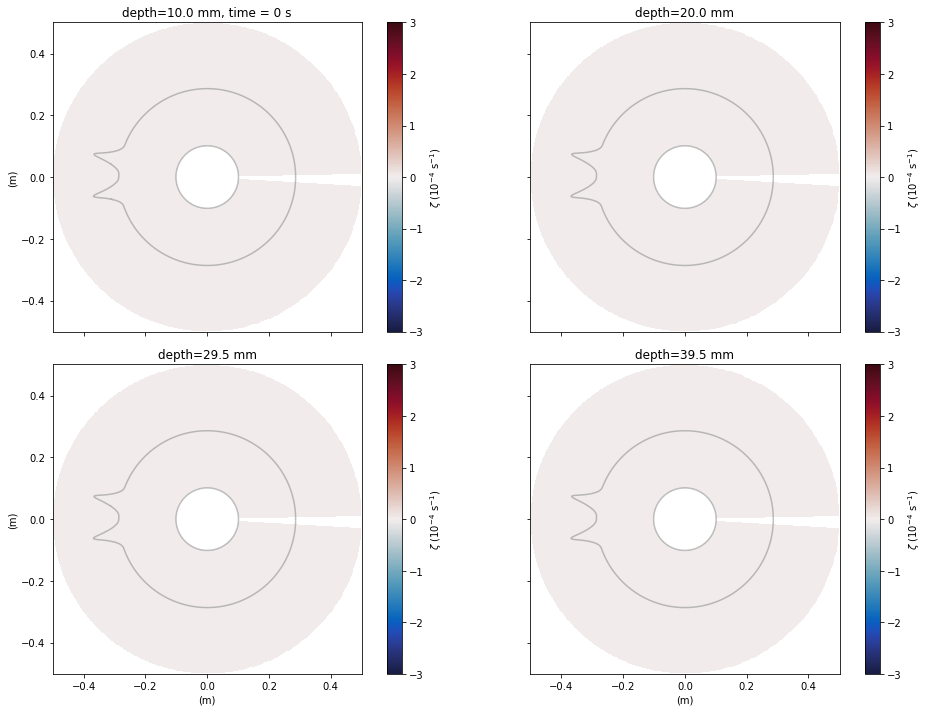

time = 0 s


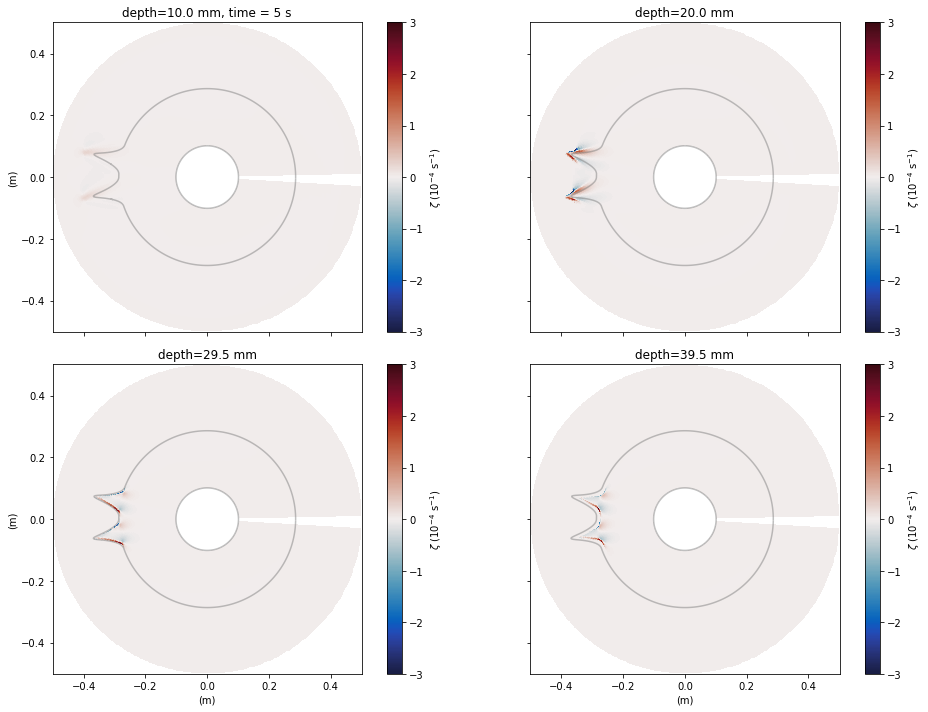

time = 5 s


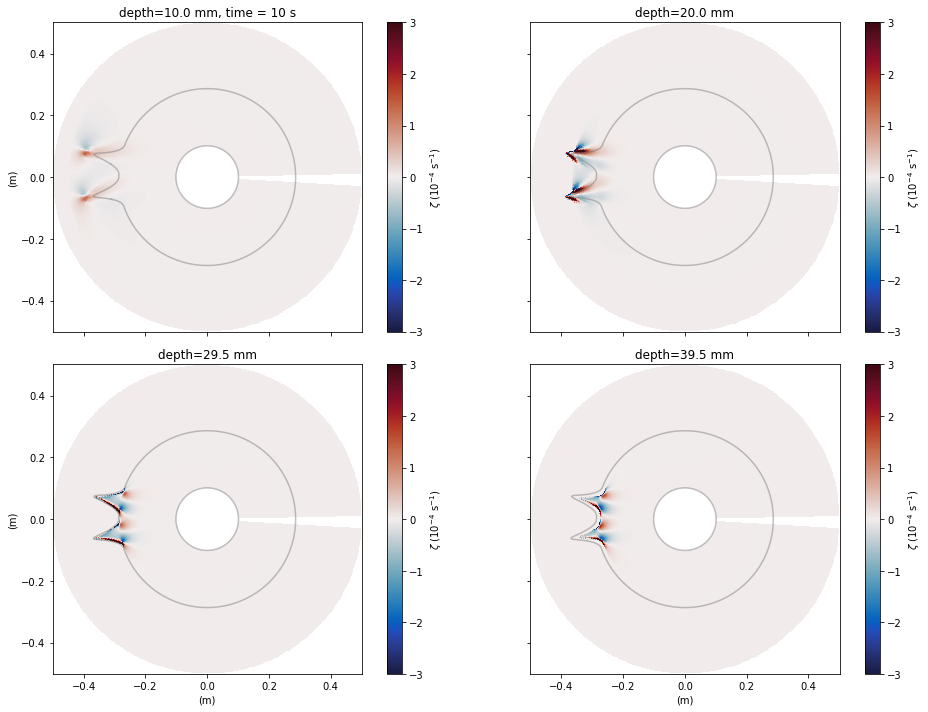

time = 10 s


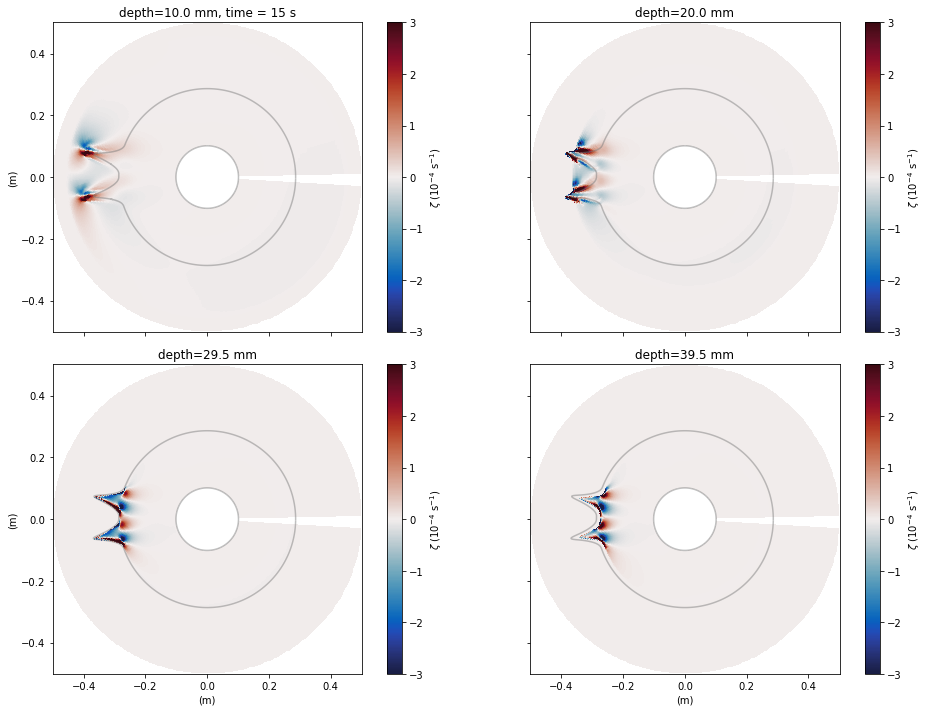

time = 15 s


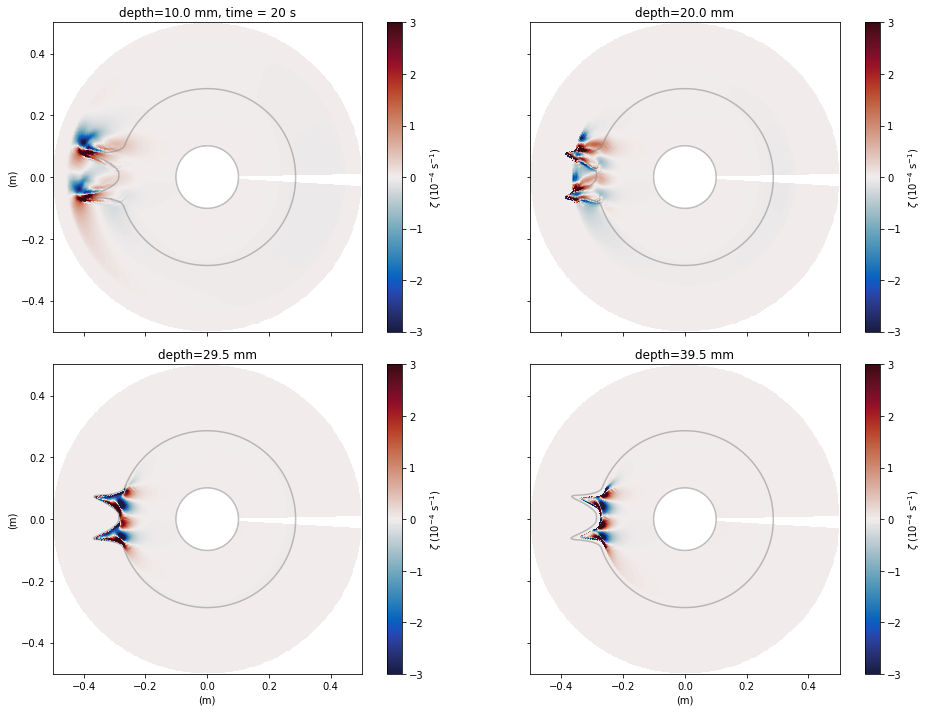

time = 20 s


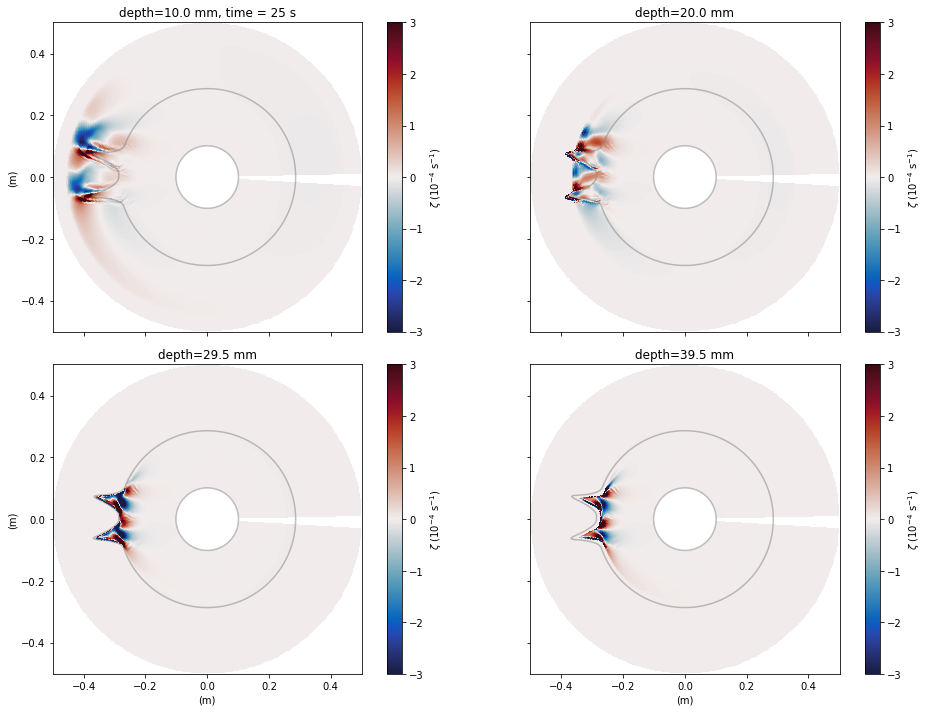

time = 25 s


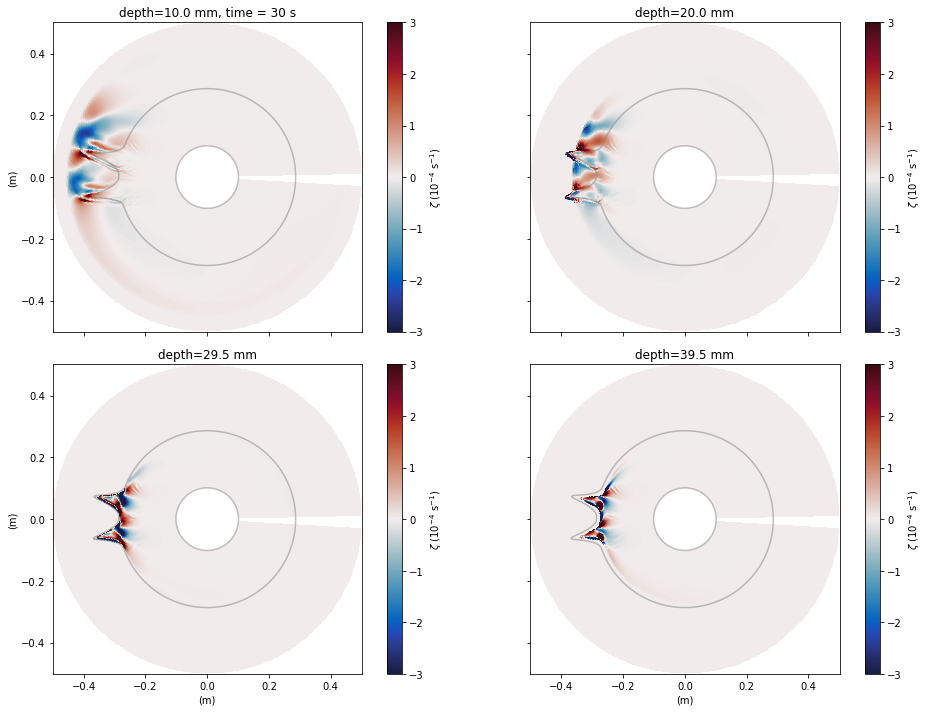

time = 30 s


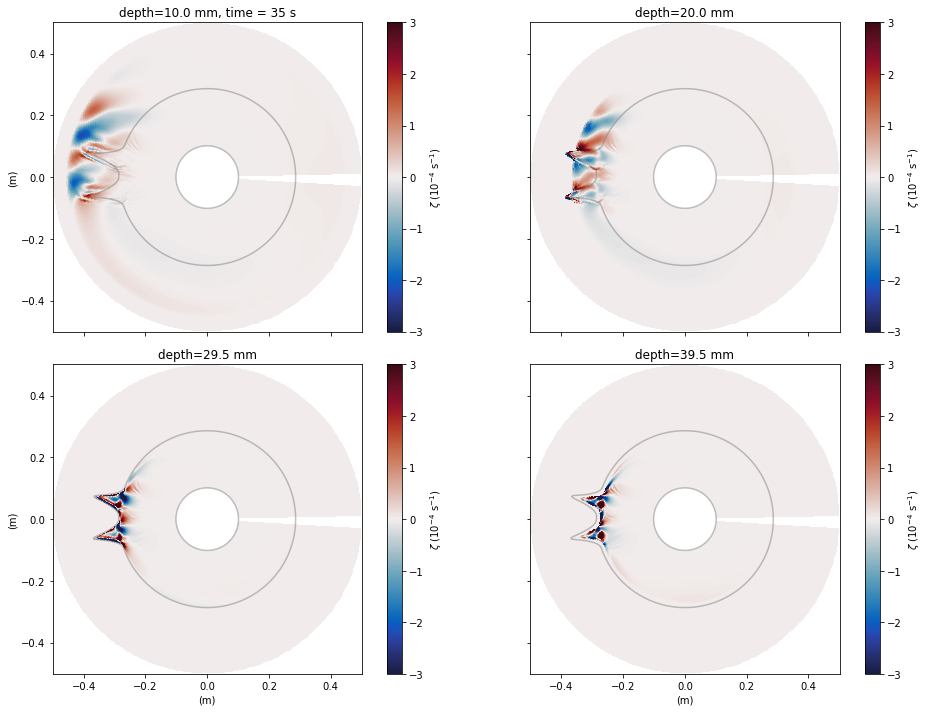

time = 35 s


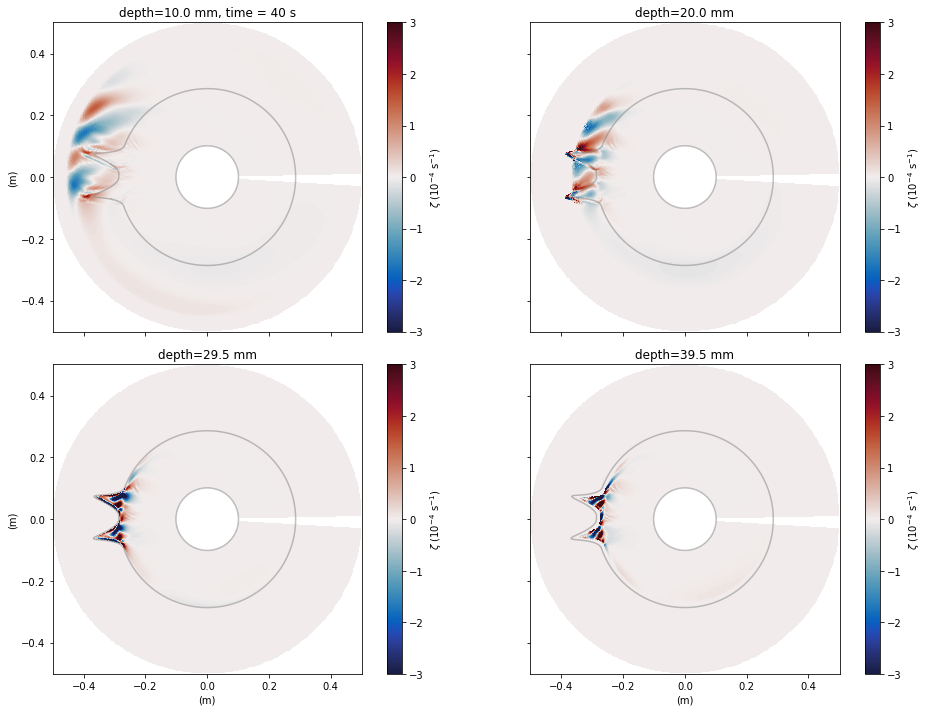

time = 40 s


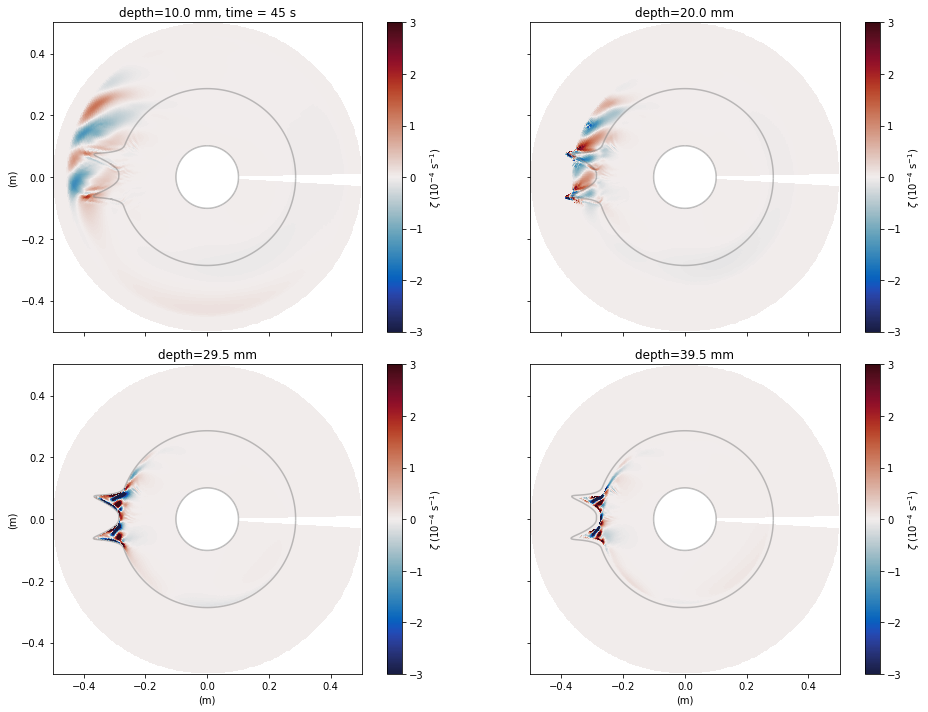

time = 45 s


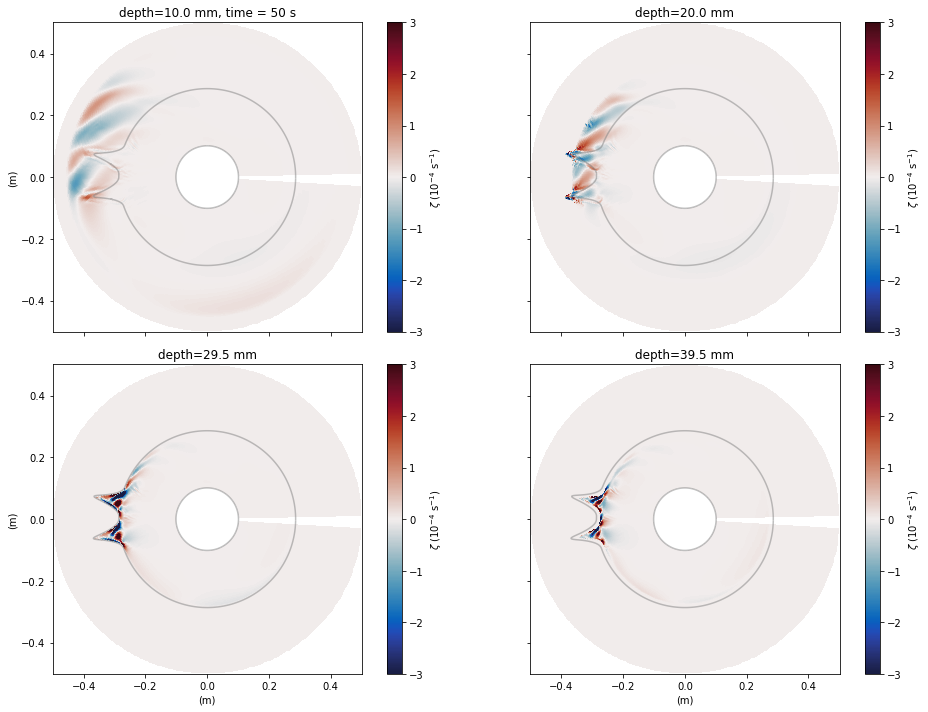

time = 50 s


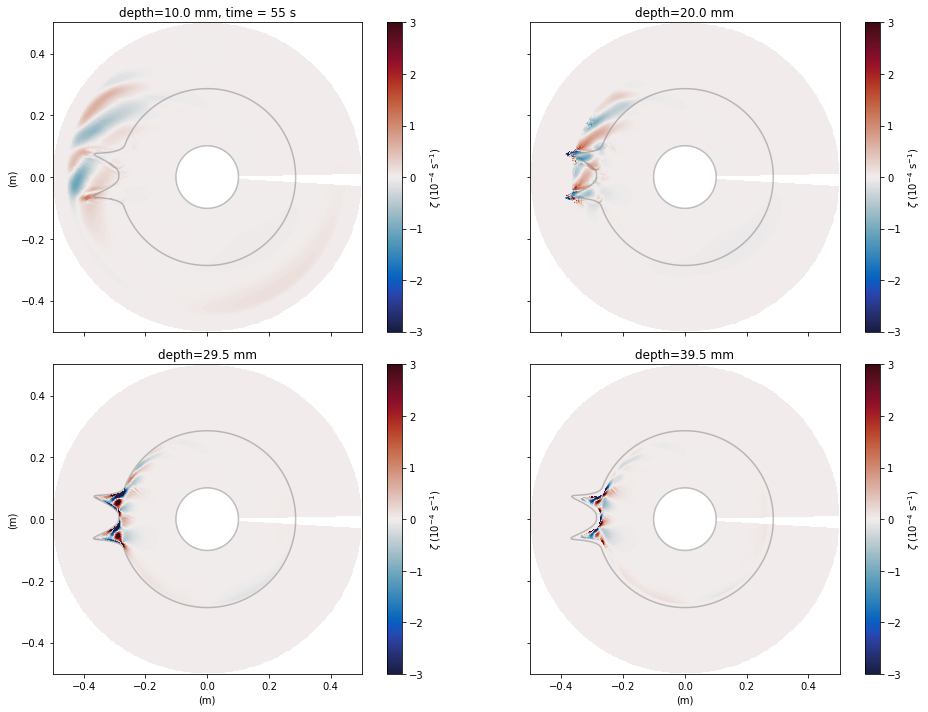

time = 55 s


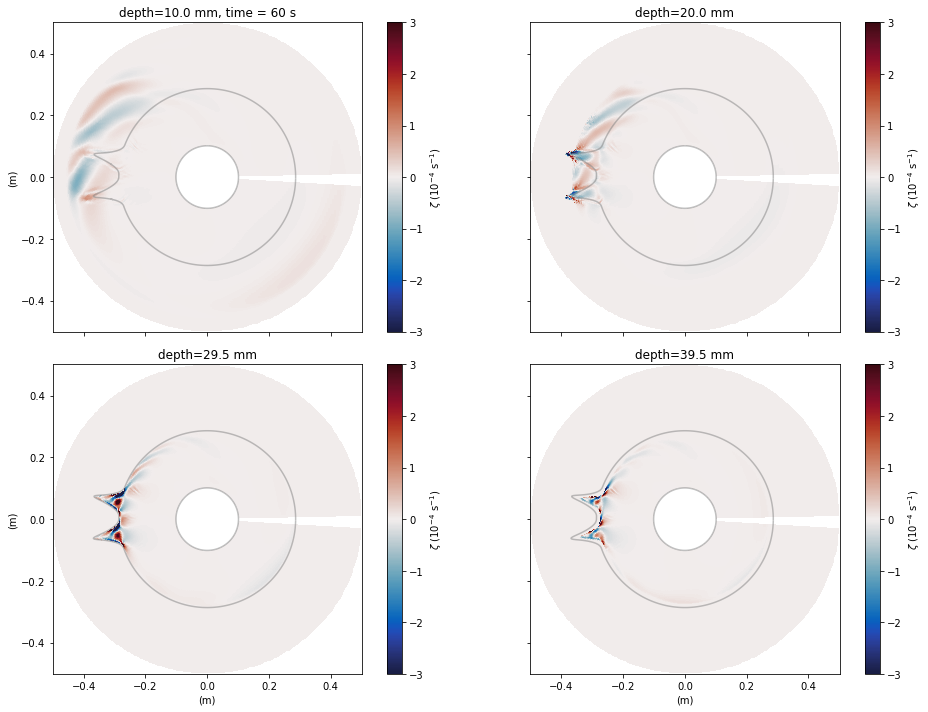

time = 60 s


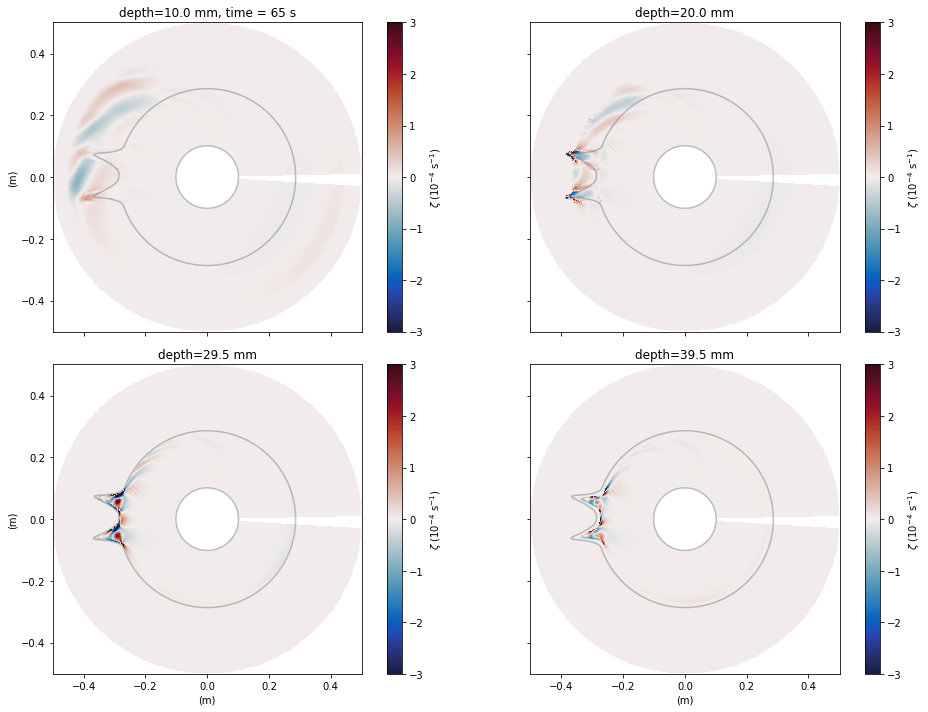

time = 65 s


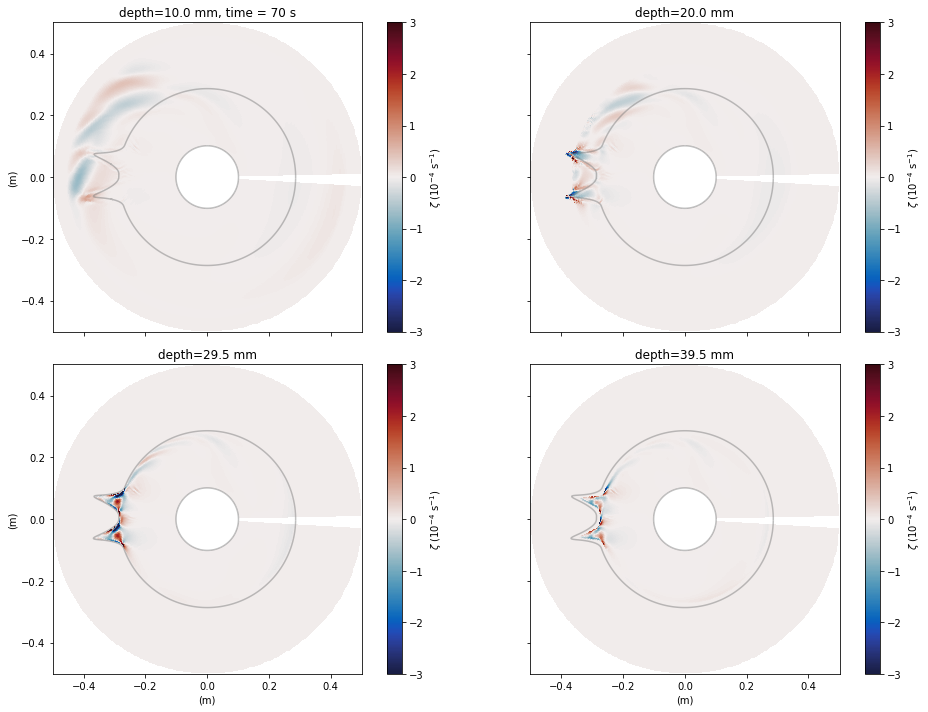

time = 70 s


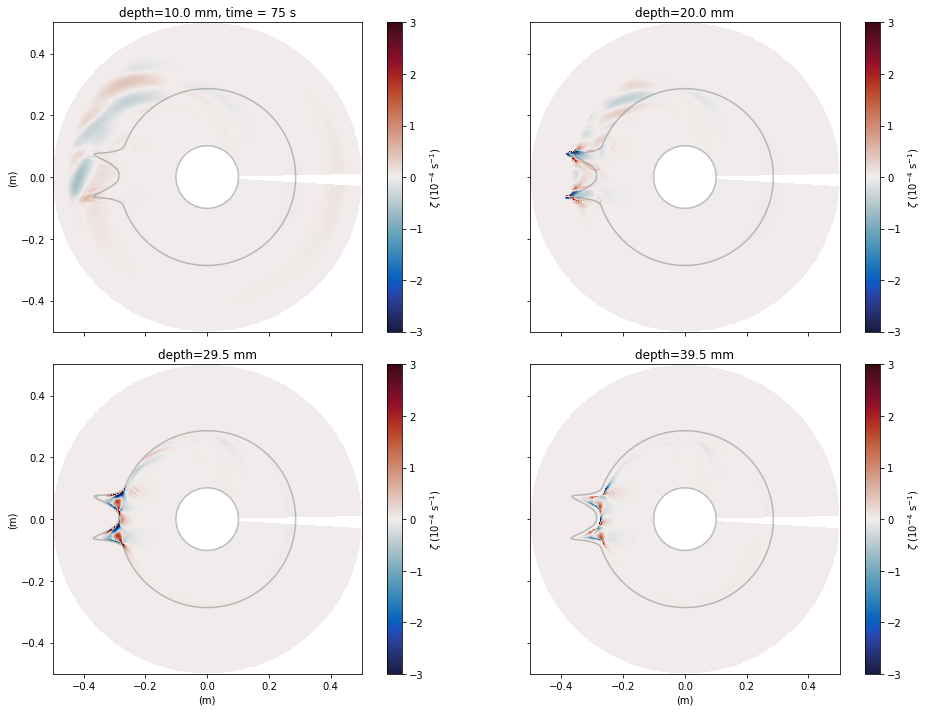

time = 75 s


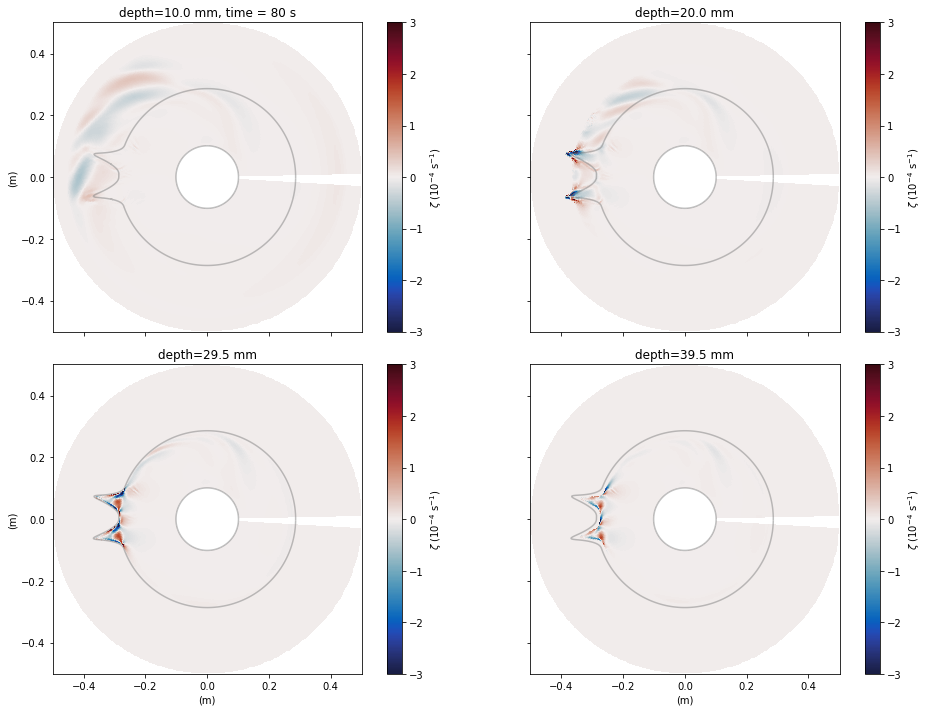

time = 80 s


In [8]:
for tt in range(time_len):
    zeta = get_vel_halfdom(state, Th, R, maskC, tt=tt)
    vmin=-3
    vmax=3
    cmap = cmo.cm.balance
    fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, sharex=True, sharey=True, figsize=(14,10))

    pc = ax1.pcolormesh(xmesh[1:-1,1:-1],ymesh[1:-1,1:-1],1E4*zeta[int(10/0.5),:,:], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(pc, ax=ax1, label=r'$\zeta$ ($10^{-4}$ s$^{-1}$)')
    ax1.set_title(f'depth={10.0} mm, time = {tt*dt} s')
    pc = ax2.pcolormesh(xmesh[1:-1,1:-1],ymesh[1:-1,1:-1],1E4*zeta[int(20/0.5),:,:], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(pc, ax=ax2, label=r'$\zeta$ ($10^{-4}$ s$^{-1}$)')
    ax2.set_title(f'depth={20.0} mm')
    pc = ax3.pcolormesh(xmesh[1:-1,1:-1],ymesh[1:-1,1:-1],1E4*zeta[int(29.5/0.5),:,:], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(pc, ax=ax3, label=r'$\zeta$ ($10^{-4}$ s$^{-1}$)')
    ax3.set_title(f'depth={29.5} mm')
    pc = ax4.pcolormesh(xmesh[1:-1,1:-1],ymesh[1:-1,1:-1],1E4*zeta[int(39.5/0.5),:,:], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(pc, ax=ax4, label=r'$\zeta$ ($10^{-4}$ s$^{-1}$)')
    ax4.set_title(f'depth={39.5} mm')
    
    ax3.set_xlabel('(m)')
    ax4.set_xlabel('(m)')
    ax1.set_ylabel('(m)')
    ax3.set_ylabel('(m)')
    
    for ax in [ax1,ax2,ax3,ax4]:
        ax.contour(xmesh,ymesh,Depth,levels=[0.029],colors='0.5', alpha=0.5)
        ax.set_aspect(1)
    plt.tight_layout()
    plt.savefig('vort/run%02d_vort_%02d.jpg' %(run,tt) )
    plt.show()
    
    print(f'time = {tt*dt} s')

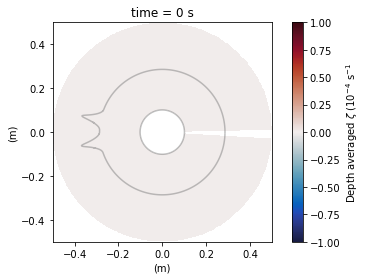

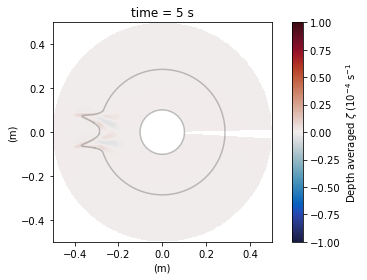

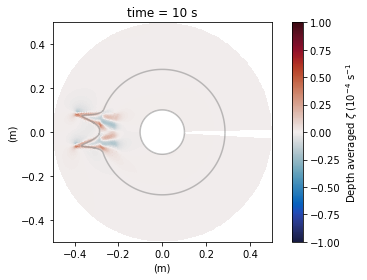

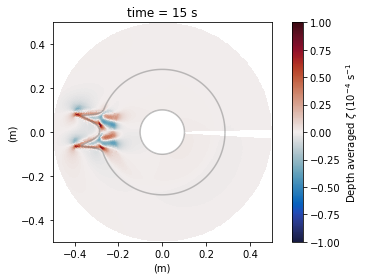

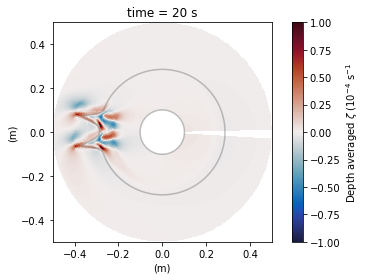

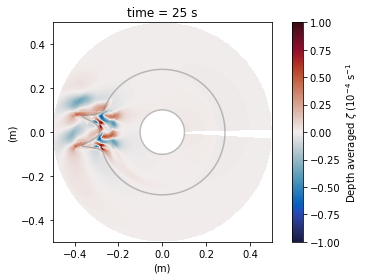

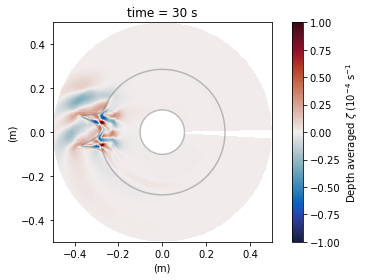

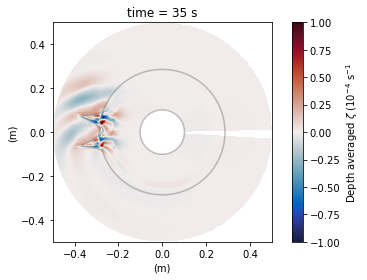

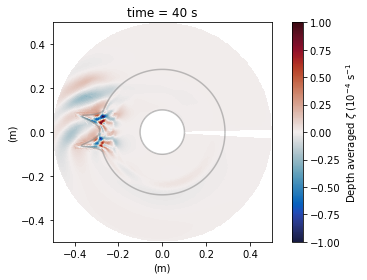

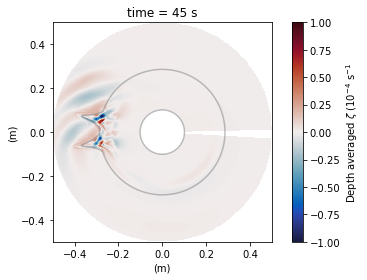

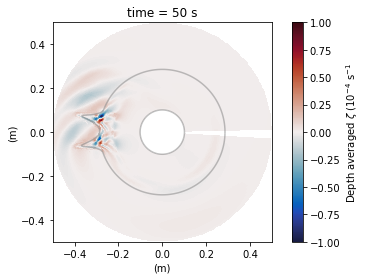

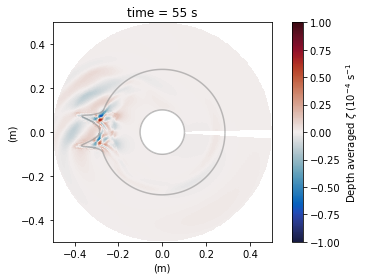

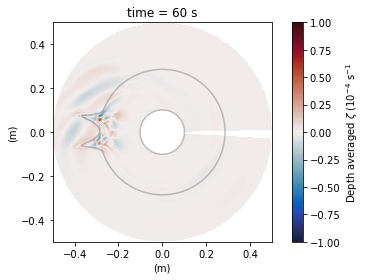

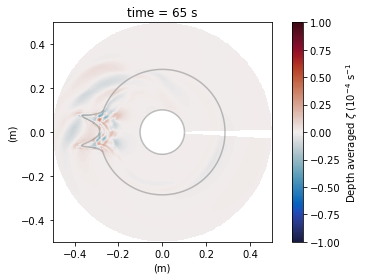

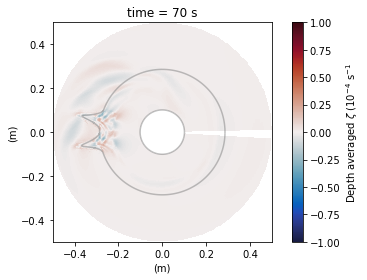

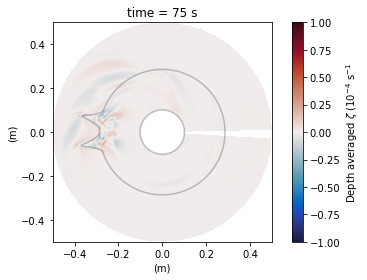

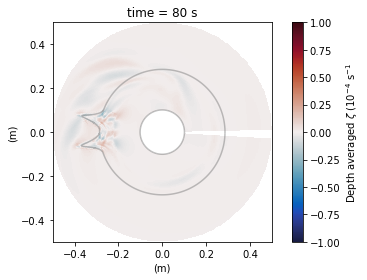

In [9]:
# vertically averaged vorticity
dz = grid.Zp1.data[1:]-grid.Zp1.data[:-1]
dzs = np.expand_dims(np.expand_dims(dz, 1),2)
dzs = dzs + np.zeros(zeta.shape)

for tt in range(time_len):
    zeta = get_vel_halfdom(state, Th, R, maskC, tt=tt)
    dep_avg_zeta = np.nansum(1E4*zeta*dzs,axis=0)/np.nansum(dzs,axis=0)
    vmin = -1
    vmax = 1
    cmap = cmo.cm.balance
    fig,ax1 = plt.subplots(1,1, sharex=True, sharey=True)
    pc = ax1.pcolormesh(xmesh[1:-1,1:-1],ymesh[1:-1,1:-1],dep_avg_zeta, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(pc, ax=ax1, label=r'Depth averaged $\zeta$ ($10^{-4}$ s$^{-1}$')
    ax1.contour(xmesh,ymesh,Depth,levels=[0.029],colors='0.5', alpha=0.5)
    ax1.set_aspect('equal')
    ax1.set_xlabel('(m)')
    ax1.set_ylabel('(m)')
    ax1.set_title(f'time = {tt*dt} s')
    plt.tight_layout()
    plt.savefig('dep_avg_vort/run%02d_vort_dep_avg_%02d.jpg' %(run, tt))
    plt.show()